In [4]:
# pip install pennylane 

In [5]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

#The parameter-shift rule

In [8]:

# set the random seed
np.random.seed(42)

# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, diff_method="parameter-shift", interface="autograd")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")

    qml.RX(params[3], wires=0)
    qml.RY(params[4], wires=1)
    qml.RZ(params[5], wires=2)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern="ring")
    return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

In [9]:
# initial parameters
params = np.random.random([6], requires_grad=True)

print("Parameters:", params)
print("Expectation value:", circuit(params))

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation value: -0.11971365706871566


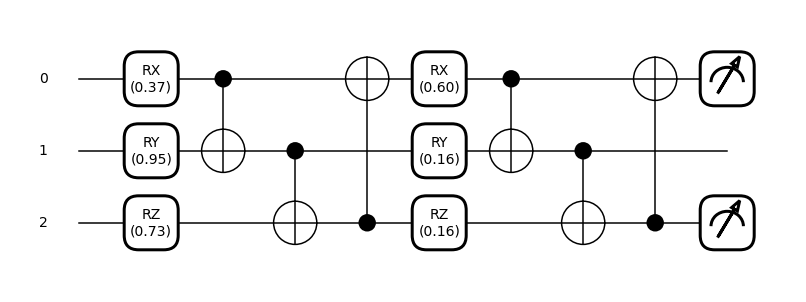

In [10]:
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [11]:
#parameter_shift for one tetha
def parameter_shift_term(qnode, params, i):
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted) # backward evaluation

    return 0.5 * (forward - backward)



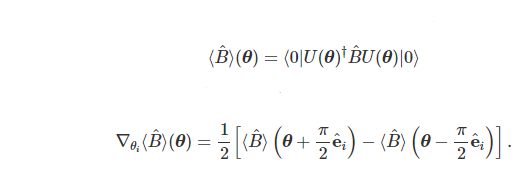

In [16]:
# gradient with respect to the first parameter
print(parameter_shift_term(circuit, params,0))

-0.06518877224958124


In [17]:
def parameter_shift(qnode, params):
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode, params, i)

    return gradients

In [18]:

print(parameter_shift(circuit, params))

[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
 -7.61067572e-01  4.16333634e-17]


we can directly compute quantum gradients of QNodes using PennyLane’s built in qml.gradients module:

In [19]:
print(qml.gradients.param_shift(circuit)(params))

[-6.51887722e-02 -2.72891905e-02 -2.77555756e-17 -9.33934621e-02
 -7.61067572e-01  4.16333634e-17]


If you count the number of quantum evaluations, you will notice that we had to evaluate the circuit 2*len(params) number of times in order to compute the quantum gradient with respect to all parameters. While reasonably fast for a small number of parameters, as the number of parameters in our quantum circuit grows, so does both

the circuit depth (and thus the time taken to evaluate each expectation value or ‘forward’ pass), and

the number of parameter-shift evaluations required.

Both of these factors increase the time taken to compute the gradient with respect to all parameters.



##Benchmarking

In [20]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift", interface="autograd")
def circuit(params):
    qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

# initialize circuit parameters
param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=15)
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
print(params.size)
print(circuit(params))

180
0.8947771876917631


In [21]:
import timeit

reps = 3  #number of ensembel 
num = 10  #number of repitation of each ensemble
times = timeit.repeat("circuit(params)", globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num

print(f"Forward pass (best of {reps}): {forward_time} sec per loop")

Forward pass (best of 3): 0.03372562509998715 sec per loop


In [23]:
# create the gradient function
grad_fn = qml.grad(circuit)


times = timeit.repeat("grad_fn(params)", globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num

print(f"Gradient computation (best of {reps}): {backward_time} sec per loop")

Gradient computation (best of 3): 17.234633478600017 sec per loop


In [24]:
print(2 * forward_time * params.size)

12.141225035995374


#Backpropagation
https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd